In [7]:
import polars as pl

matchs_df = pl.read_parquet('BL_23_24_match_events.parquet')

matchs_df.head()

event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,body_part_type,set_piece_type,result,success,duel_type,is_under_pressure,pass_type,goalkeeper_type,match_id,card_type
str,str,i64,duration[μs],duration[μs],str,str,str,str,f64,f64,f64,f64,str,str,str,str,bool,str,bool,str,str,i32,str
"""4858179098""","""PASS""",1,0µs,332ms,"""alive""","""33""","""33""","""204""",0.5,0.5,null,null,null,"""RIGHT_FOOT""","""KICK_OFF""","""INCOMPLETE""",false,null,null,null,null,122838,null
"""4858179099""","""GENERIC:NO_VIDEO""",1,332ms,null,"""alive""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,122838,null
"""4858179100""","""GENERIC:RECEPTION""",1,1s 651ms,null,"""alive""","""33""","""33""","""1202""",0.20381,0.430882,null,null,null,null,null,null,null,null,null,null,null,122838,null
"""4858179101""","""CARRY""",1,1s 651100µs,4s 193ms,"""alive""","""33""","""33""","""1202""",0.20381,0.430882,0.205714,0.501471,null,"""RIGHT_FOOT""",null,"""COMPLETE""",true,null,null,null,null,122838,null
"""4858179102""","""PASS""",1,4s 192999µs,6s 904999µs,"""alive""","""33""","""33""","""1202""",0.205714,0.501471,0.627619,0.091176,null,"""RIGHT_FOOT""",null,"""INCOMPLETE""",false,null,null,null,null,122838,null


In [ ]:
# would ball_owning_team be something to keep in this regression?
events_df = events.to_df(engine="polars")

features = ['timestamp', 'end_timestamp', 'ball_owning_team', 'player_id', 'coordinates_x', 'coordinates_y', 
            'end_coordinates_x', 'end_coordinates_y', 'receiver_player_id',	'body_part_type', 'set_piece_type',	'result', 'success', 'is_under_pressure',
            'pass_type', 'duel_type', 'goalkeeper_type']

body_part_mapping = {
    "RIGHT_FOOT" : 1,
    "HEAD" : 2,
    "KEEPER_ARM" : 3
}

pass_type_mapping = {
    "HIGH_PASS" : 1,
    "ASSIST" : 2,
    "HAND_PASS" : 3,
    "HEAD_PASS" : 4,
    "CROSS" : 5,
    "SHOT_ASSIST" : 6,
    "CHIPPED_PASS" : 7,
    None : 0
}

pass_events_df = (
    events_df
    .filter(events_df['event_type'] == 'PASS')
    .select(features)
)
'''
(pl.col('end_timestamp') - pl.col('timestamp'))
    .cast(pl.Float32, strict=True)
    .fill_null(0)
    .alias('pass_time'),
'''
pass_events_df = pass_events_df.with_columns(
    # Pass duration
    (pl.col('end_timestamp') - pl.col('timestamp'))
    .dt.total_milliseconds()
    .cast(pl.Float32)
    .truediv(1000)
    .fill_null(0)
    .alias('pass_time'),
    

    # Pass distance (Euclidean)
    ((pl.col('end_coordinates_x') - pl.col('coordinates_x'))**2 + 
     (pl.col('end_coordinates_y') - pl.col('coordinates_y'))**2)
        .sqrt()
        .fill_null(0)
        .alias('pass_distance'),

    # Distance from pass origin to goal (1.0, 0.5)
    ((1.0 - pl.col('coordinates_x'))**2 + 
     (0.5 - pl.col('coordinates_y'))**2)
        .sqrt()
        .alias('start_dist_to_goal'),
    
    # Distance from pass destination to goal (1.0, 0.5)
    ((1.0 - pl.col('end_coordinates_x'))**2 + 
     (0.5 - pl.col('end_coordinates_y'))**2)
        .sqrt()
        .alias('end_dist_to_goal'),
    
    # Body part encoding
    pl.col("body_part_type")
        .replace(body_part_mapping)
        .cast(pl.Int64, strict=True)
        .fill_null(0)
        .alias("body_part_int"),
    
    # Pass type encoding
    pl.col("pass_type")
        .replace(pass_type_mapping)
        .cast(pl.Int64, strict=True)
        .fill_null(0)
        .alias("pass_type_int"),
    
    # Under pressure flag
    pl.col("is_under_pressure")
        .cast(pl.Int64, strict=True)
        .fill_null(0)
        .alias("is_under_pressure_int"),

    # pass success
    pl.col('success')
        .cast(pl.Int64, strict=True)
        .fill_null(0)
        .alias("success_int"),
)

pass_events_df = pass_events_df.with_columns(
    # Progressive flag
    ((pl.col('start_dist_to_goal') - pl.col('end_dist_to_goal')) / pl.col('start_dist_to_goal') >= 0.25)
        .and_(pl.col('success_int') == 1)
        .and_(
            ~(pl.col('coordinates_x') >= 0.85)
            .and_(pl.col('coordinates_y').is_between(0.225, 0.775))
        )
        .cast(pl.Int8)
        .alias('is_progressive'),

    pl.col('is_under_pressure').fill_null(False),
)


filtered_events = ['pass_time', 'pass_distance', 'body_part_int', 'pass_type_int', 'is_progressive', 'is_under_pressure_int', 'success_int']

filtered_events_df = pass_events_df[filtered_events]

pass_events_df


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (866221305.py, line 24)

In [ ]:
matchs_df = pl.read_parquet('BL_23_24_match_events.parquet')

def agg_pass_data(events_df, features):
    matchs_pass_event_dict = {}
    matchs_df = pl.read_json("combined_matches.json")

    pass_events_df = events_df.filter(events_df['event_type'] == 'PASS')
    
    for match_id in matchs_df['matchId']:
        matchs_pass_event_dict[match_id] = pass_events_df.filter(pass_events_df['match_id'] == match_id)
    
    return matchs_pass_event_dict

matchs_pass_df = agg_pass_data(matchs_df, features)

In [ ]:
match_id_list = [match_id for match_id, _ in matchs_pass_df.items()]

In [ ]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Filter passes for a specific team and match
team_id = '30'
team_passes = pass_events_df.filter(
    (pass_events_df['ball_owning_team'] == team_id) &
    (pass_events_df['success_int'] == 1)
)

# Create pitch and plot passes
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(pitch_type='statsbomb', orientation='portraits', view='full')
pitch.draw(ax=ax)

# Extract pass coordinates (StatsBomb uses 0-120 x 0-80)
x = team_passes['coordinates_x'].to_numpy() * 120
y = team_passes['coordinates_y'].to_numpy() * 80
end_x = team_passes['end_coordinates_x'].to_numpy() * 120
end_y = team_passes['end_coordinates_y'].to_numpy() * 80

# Plot pass arrows
pitch.arrows(x, y, end_x, end_y, width=1, headwidth=4, headlength=4,
             color='blue', alpha=0.4, ax=ax)

# Plot pass origins as dots
pitch.scatter(x, y, s=50, color='blue', alpha=0.6, ax=ax, label='Pass Origin')

ax.set_title(f'Team {team_id} - Completed Passes', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
match_metadata_dict = extract_events_metadata(events)
match_metadata_dict

{'team_0_id': '30',
 'team_0_name': 'VfL Wolfsburg',
 'team_0_ground': home,
 'team_0_starting_formation': '4-3-3',
 'team_0_formations': <TimeContainer>,
 'team_1_id': '432',
 'team_1_name': '1. FC Heidenheim 1846',
 'team_1_ground': away,
 'team_1_starting_formation': '4-1-3-2',
 'team_1_formations': <TimeContainer>,
 'roster_0': {'957': 'Yannick Gerhardt',
  '996': 'Koen Casteels',
  '3503': 'Jonas Wind',
  '4669': 'Ridle Baku',
  '7369': 'Mattias Svanberg',
  '7755': 'Vaclav Cerny',
  '13276': 'Sebastiaan Bornauw',
  '13567': 'Joakim Maehle',
  '16789': 'Lovro Majer',
  '27568': 'Maxence Lacroix',
  '29485': 'Cédric Zesiger',
  '30434': 'Pavao Pervan',
  '32706': 'Aster Vranckx',
  '33303': 'Nicolas Cozza',
  '38637': 'Moritz Jenz',
  '49887': 'Tiago Tomás',
  '53653': 'Patrick Wimmer',
  '56370': 'Jakub Kaminski',
  '57263': 'Kevin Paredes',
  '104738': 'Dzenan Pejcinovic'},
 'roster_1': {'1313': 'Jonas Föhrenbach',
  '1443': 'Benedikt Gimber',
  '1457': 'Marnon Busch',
  '10244':

In [27]:
# creates a network based on the frequency of passes (future iterations will attempt to consider pass length, type, time, contest, turnover, etc)
def populate_pass_dict(match_metadata_dict, events):
    # define directed graph, roster dict, df filters
    roster_pass_dict = {
        match_metadata_dict['team_0_id'] : match_metadata_dict['roster_0'],
        match_metadata_dict['team_1_id'] : match_metadata_dict['roster_1']
    }
    pass_events = events.filter(events['event_type'] == 'PASS')

    # Initialize pass dictionaries
    roster_ids = [match_metadata_dict['team_0_id'], match_metadata_dict['team_1_id']]
    for roster_id in roster_ids:
        for player_id in roster_pass_dict[roster_id]:
            roster_pass_dict[roster_id][player_id] = [roster_pass_dict[roster_id][player_id], {}]

    # create initial data dicts
    pass_events = events_df.filter(events_df['event_type'] == 'PASS')

    # map fields to polars ids
    fields_to_index = {
        'ball_owning_team' : 6,
        'team_id' : 7,
        'player_id' : 8,
        'receiver_player_id' : 13,
        'success' : 17
    }
    
    # increment player's pass frequency using cond statements
    for pass_event in pass_events.iter_rows():
        # if player makes a completed pass to a teammate, increment their pass frequency by 1
        if pass_event[13] is not None and pass_event[17]:
            team = pass_event[6]
            player = pass_event[8]
            receiver = pass_event[13]
            
            # check if player exists in team roster
            if player not in roster_pass_dict[team]:
                print(f"Player {player} not found in team {team}")
                continue
            
            #print(roster_pass_dict[team][player][1])
            roster_pass_dict[team][player][1][receiver] = roster_pass_dict[team][player][1].get(receiver, 0) + 1

    return roster_pass_dict

In [28]:
match_metadata_dict = extract_events_metadata(events)
roster_pass_dict = populate_pass_dict(match_metadata_dict, events_df)
roster_pass_dict['30'].keys()

Player 29485 not found in team 432
Player 29485 not found in team 432


dict_keys(['957', '996', '3503', '4669', '7369', '7755', '13276', '13567', '16789', '27568', '29485', '30434', '32706', '33303', '38637', '49887', '53653', '56370', '57263', '104738'])

In [29]:
team_network_ids = {
    '30' : ['VfL Wolfsburg', nx.DiGraph()],
    '432' : ['1. FC Heidenheim 1846', nx.DiGraph()]
}

# TODO: Iterate through pass_dict and create network based on frequency
# create pass network for individual teams
def create_pass_network(roster_pass_dict, team_network_ids):
    DG_dict = {}
    for team_network in team_network_ids.items():
        team_id = team_network[0]
        team_name = team_network[1][0]
        team_DG = team_network[1][1]
        pass_list = []
        for roster in roster_pass_dict[team_id].items():
            passer_id = roster[0]
            print(passer_id)
            passer_name = roster[1][0]
            print(passer_name)
            passer_passes = roster[1][1]
            print(passer_passes)
            for receiver_id, pass_freq in passer_passes.items():
                #print(receiver_id, pass_freq)
                pass_list.append((passer_id, receiver_id, pass_freq))
        team_DG.add_weighted_edges_from(pass_list)
        DG_dict[team_id] = team_DG
    return DG_dict
pass_network_dict = create_pass_network(roster_pass_dict, team_network_ids)
pass_network_dict

957
Yannick Gerhardt
{'13567': 4, '16789': 2, '27568': 3, '29485': 3, '7369': 2, '4669': 1}
996
Koen Casteels
{'957': 2, '29485': 6, '13567': 1, '27568': 4, '4669': 4}
3503
Jonas Wind
{'4669': 1, '16789': 1, '29485': 1, '7369': 1, '13567': 2}
4669
Ridle Baku
{'996': 3, '957': 3, '7369': 5, '27568': 6, '7755': 6, '3503': 2, '13567': 1}
7369
Mattias Svanberg
{'7755': 4, '957': 2, '4669': 4, '16789': 2, '27568': 1, '3503': 2}
7755
Vaclav Cerny
{'16789': 2, '4669': 2, '27568': 1, '7369': 1, '3503': 1}
13276
Sebastiaan Bornauw
{}
13567
Joakim Maehle
{'3503': 4, '53653': 3, '16789': 5, '29485': 15, '27568': 1, '7369': 1}
16789
Lovro Majer
{'7755': 4, '53653': 1, '4669': 1, '7369': 2, '27568': 1, '13567': 1, '957': 2, '29485': 2, '3503': 1, '996': 1}
27568
Maxence Lacroix
{'29485': 20, '4669': 6, '7369': 3, '957': 4, '7755': 2, '996': 3}
29485
Cédric Zesiger
{'27568': 14, '13567': 16, '3503': 1, '16789': 7, '996': 4, '53653': 3, '957': 1}
30434
Pavao Pervan
{}
32706
Aster Vranckx
{}
33303
Nic

{'30': <networkx.classes.digraph.DiGraph at 0x14ea7b170>,
 '432': <networkx.classes.digraph.DiGraph at 0x14ea793a0>}

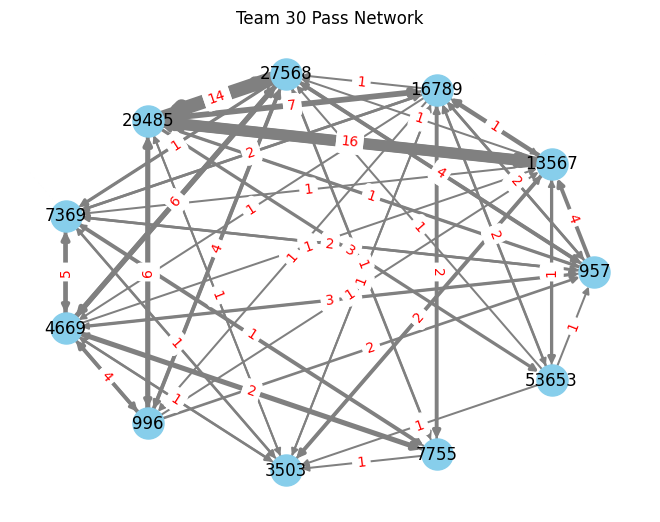

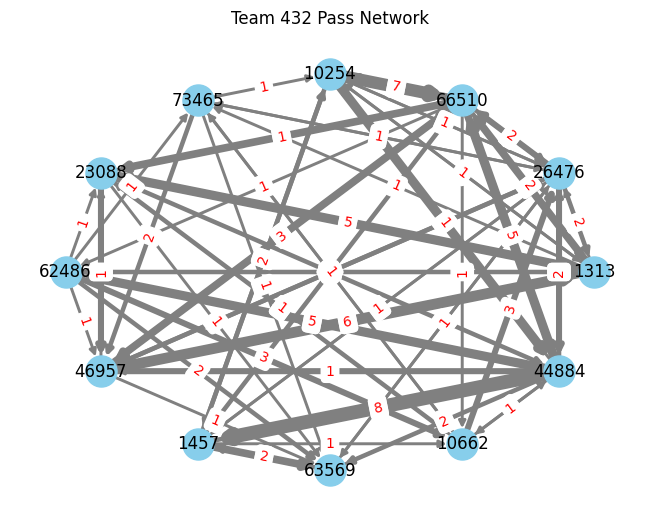

In [30]:
def draw_pass_network(pass_network, team_id):
    DG = pass_network
    pos = nx.circular_layout(DG)
    
    # extract edge weights for line thickness
    edges = DG.edges(data=True)
    weights = [d.get('weight', 1) for _, _, d in edges]
    
    # normalize weights to a reasonable visual range (1-10)
    max_w = max(weights) if weights else 1
    widths = [1 + 9 * (w / max_w) for w in weights]
    
    nx.draw(DG, pos, with_labels=True, node_color='skyblue', node_size=500,
            edge_color='gray', width=widths)
    
    edge_labels = nx.get_edge_attributes(DG, 'weight')
    nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(f"Team {team_id} Pass Network")
    plt.axis('off')
    plt.show()

#draw_pass_network(pass_network_dict['30'])
for team_id, team_network in pass_network_dict.items():
    draw_pass_network(pass_network_dict[team_id], team_id)

In [31]:

EXAMPLE_LINEUPS = {
    '30': ['957', '996', '3503', '4669', '7369', '7755', '13567', '16789', '27568', '29485', '53653']
}
(roster_pass_dict['30'].keys())

dict_keys(['957', '996', '3503', '4669', '7369', '7755', '13276', '13567', '16789', '27568', '29485', '30434', '32706', '33303', '38637', '49887', '53653', '56370', '57263', '104738'])

In [32]:
pass_events_list = pass_events_df.select([
    pl.col('player_id').alias('player_id'),
    pl.col('receiver_player_id').alias('receiver_player_id'),
    pl.col('success_int').cast(pl.Boolean).alias('success'),
    pl.col('is_progressive').cast(pl.Boolean).alias('is_progressive'),
    pl.col('end_coordinates_x').alias('end_coordinates_x'),
    pl.col('is_under_pressure').alias('is_under_pressure'),
]).to_dicts()

def build_pass_network(pass_events, lineup, min_passes=1):

    G = nx.DiGraph()
    G.add_nodes_from(lineup)

    edge_data = {}
    for p in pass_events:
        passer, reciever = p['player_id'], p['receiver_player_id']
        if passer not in lineup or reciever not in lineup:
            continue
        pass_key = (passer, reciever)
        if pass_key not in edge_data:
            edge_data[pass_key] = {
                'total_passes': 0,
                'completed_passes': 0,
                'progressive_passes': 0,
                'end_x_sum': 0,
                'contested_passes': 0,
            }
        edge_data[pass_key]['total_passes'] += 1
        edge_data[pass_key]['completed_passes'] += int(p.get('success', True))
        edge_data[pass_key]['progressive_passes'] += int(p.get('is_progressive', True))
        edge_data[pass_key]['end_x_sum'] += p.get("end_coordinates_x", 60.0)
        edge_data[pass_key]['contested_passes'] += p.get('is_under_pressure', True)

    for (passer, reciever), d in edge_data.items():
        if d['total_passes'] < min_passes:
            continue
        G.add_edge(
            passer, reciever,
            weight=d['completed_passes'],
            total=d['total_passes'],
            completion_rate=d['completed_passes'] / d['total_passes'],
            progressive=d['progressive_passes'],
            contested_passes=d['contested_passes'],
            avg_x_end=d['end_x_sum'] / d['total_passes'],
            composite_weight=(
                0.5 * d['completed_passes']
                + 0.25 * d['progressive_passes']
                + 0.2 * d['total_passes'] * (d['completed_passes'] / d['total_passes'])
                + 0.05 * d['contested_passes']
            ),
        )
    return G

    
pass_net = build_pass_network(pass_events_list, EXAMPLE_LINEUPS['30'])
#pass_net
type(match_metadata_dict['team_0_id'])

str

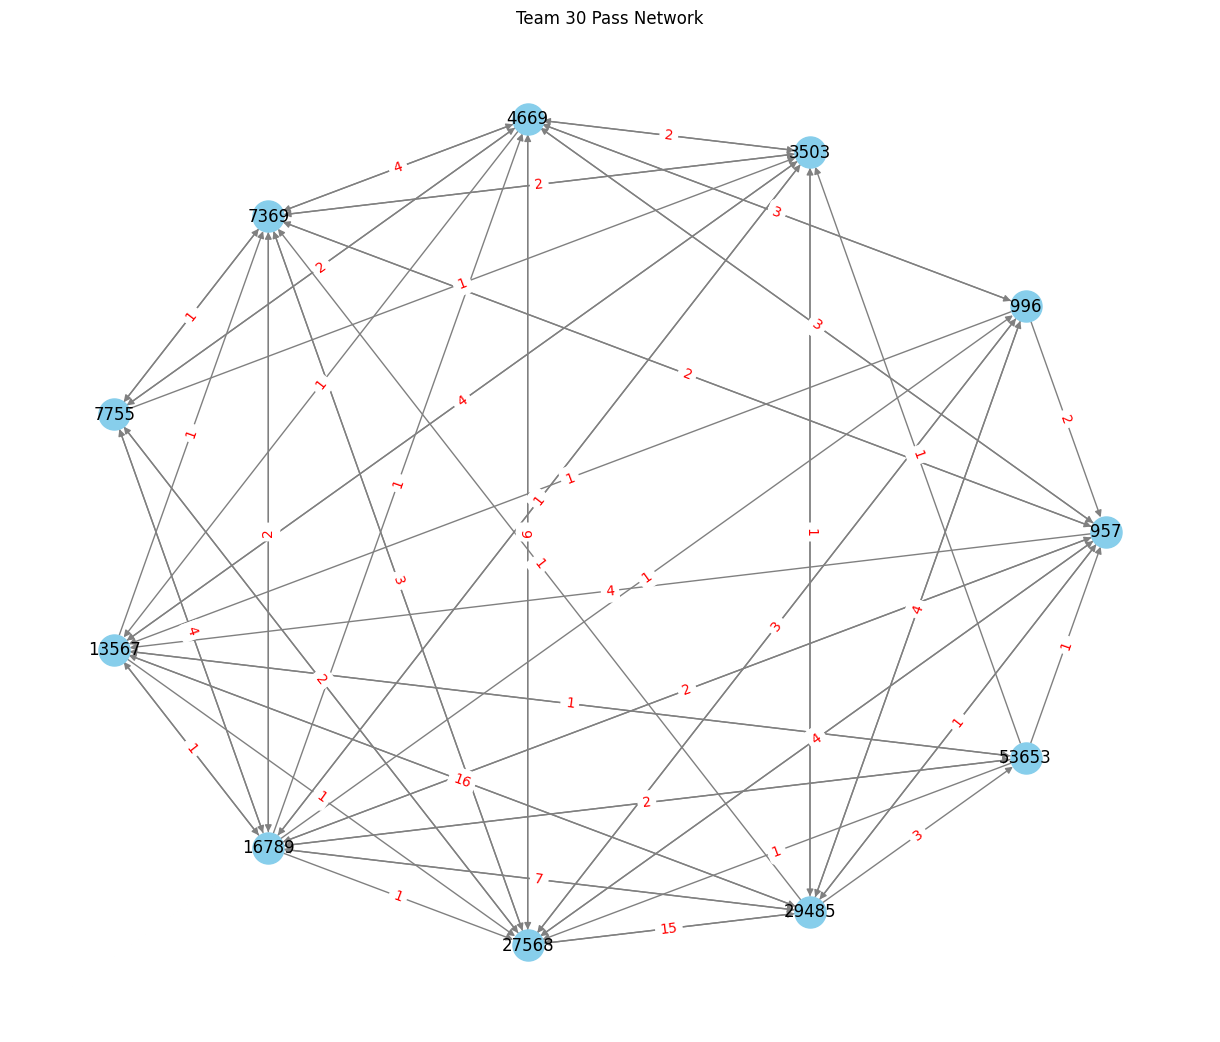

In [33]:
plt.figure(figsize=(12, 10))
pos = nx.circular_layout(pass_net)
nx.draw(pass_net, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
edge_labels = nx.get_edge_attributes(pass_net, 'weight')
nx.draw_networkx_edge_labels(pass_net, pos, edge_labels=edge_labels, font_color='red')
plt.title(f"Team 30 Pass Network")
plt.axis('off')
plt.show()

In [34]:
def compute_player_metrics(G):

    metrics = {}

    # percentage of possible connections a player has to other players
    degree_centrality = nx.degree_centrality(G)
    # connect between players (i.e. how is the passing middleman)
    betweenness_centrality = nx.betweenness_centrality(G, weight="weight", normalized=True)
    # determines what highly targeted player pass to other highly targeted players
    pagerank = nx.pagerank(G, weight='weight', alpha=0.85)
    # which passing partners pass with each other (passing triangles)
    clustering_coeff = nx.clustering(G, weight='weight')

    undir_G = G.to_undirected()
    try:
        # how many connections your connections have
        ev_centrality = nx.eigenvector_centrality_numpy(undir_G, weight='weight')
    except Exception:
        ev_centrality = {n: 0.0 for n in G.nodes()}

    for player in G.nodes():
        in_strength = sum(d['weight'] for i, j, d in G.in_edges(player, data=True))
        out_strength = sum(d['weight'] for i, j, d in G.out_edges(player, data=True))
        metrics[player] = {
            'degree_centrality': degree_centrality.get(player, 0),
            'betweenness_centrality': betweenness_centrality.get(player, 0),
            'pagerank': pagerank.get(player, 0),
            'clustering_coeff': float(clustering_coeff.get(player, 0)),
            'ev_centrality': float(ev_centrality.get(player, 0)),
            'in_strength': in_strength,
            'out_strength': out_strength,
        }

    return metrics


player_metrics = compute_player_metrics(pass_net)
#player_metrics

In [35]:
def compute_team_metrics(G):

    n = G.number_of_nodes()
    m = G.number_of_edges()

    # edges / potential edges (high means frequent passing)
    density = nx.density(G)
    # how many passing triangles appear in network (A -> B, B -> C, C -> A)
    avg_cluster = nx.average_clustering(G, weight='weight')
    # what fraction of passes go both ways between players (A -> B and B -> A)
    reciprocity = nx.reciprocity(G) if m > 0 else 0

    # can every player reach on another via passing?
    n_strong_connected_components = nx.number_strongly_connected_components(G)
    max_strong_connected_components = max(nx.strongly_connected_components(G), key=len)
    strong_component_ratio = len(max_strong_connected_components) / n

    # how does the network fair when an edge is removed (are they dependent on one player)
    undir_G = G.to_undirected()
    try:
        algebraic_connectivity = nx.algebraic_connectivity(undir_G, weight="weight")
    except Exception:
        algebraic_connectivity = 0.0

    # how many passes are required to get between two players (lower for more direct pathes)
    try:
        G_inv = G.copy()
        for u, v, d in G_inv.edges(data=True):
            d['distance'] = 1.0 / (d['weight'] + 1e-6)
        asp = nx.average_shortest_path_length(G_inv, weight='distance')
    except nx.NetworkXError:
        asp = float('inf')
        
    # gets raw sum of progressive passes
    total_progressive_passes = sum(d.get('is_progressive', 0) for _, _, d in G.edges(data=True))

    # how evenly distributed are the passes between players?
    weights = np.array([d['weight'] for _, _, d in G.edges(data=True)], dtype=float)
    if weights.sum() > 0:
        p = weights / weights.sum()
        p = p[p > 0]
        entropy = -np.sum(p * np.log2(p))
        max_entropy = np.log2(len(p)) if len(p) > 1 else 1.0
        norm_entropy = entropy / max_entropy
    else:
        norm_entropy = 0
    
    # how central is the passing flow (ball mainly goes through one player or multiple?)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
    betweenness_centrality_vals = list(betweenness_centrality.values())
    max_bc = max(betweenness_centrality_vals)
    centralization = (sum(max_bc - b for b in betweenness_centrality_vals)
                      / ((n - 1) * (n - 2))) if n > 2 else 0
    
    return {
        'density': density,
        'avg_clustering': float(avg_cluster),
        'reciprocity': reciprocity,
        'strong_connectivity_ratio': strong_component_ratio,
        'algebraic_connectivity': float(algebraic_connectivity),
        'avg_shortest_path': asp,
        'total_progressive_passes': total_progressive_passes,
        'edge_weight_entropy': float(norm_entropy),
        'flow_centralization': centralization
    }

team_metrics_11 = compute_team_metrics(pass_net) 
team_metrics_11

{'density': 0.6272727272727273,
 'avg_clustering': 0.08578961164565863,
 'reciprocity': 0.782608695652174,
 'strong_connectivity_ratio': 1.0,
 'algebraic_connectivity': 8.786575172485728,
 'avg_shortest_path': 0.49895542146070754,
 'total_progressive_passes': 0,
 'edge_weight_entropy': 0.900752880109243,
 'flow_centralization': 0.016526748971193418}

In [ ]:
for 

In [36]:
team_metrics_10 = compute_team_metrics(pass_net)  
team_metrics_10


{'density': 0.6272727272727273,
 'avg_clustering': 0.08578961164565863,
 'reciprocity': 0.782608695652174,
 'strong_connectivity_ratio': 1.0,
 'algebraic_connectivity': 8.786575172485728,
 'avg_shortest_path': 0.49895542146070754,
 'total_progressive_passes': 0,
 'edge_weight_entropy': 0.900752880109243,
 'flow_centralization': 0.016526748971193418}

In [37]:
df_11 = pl.DataFrame(team_metrics_11)
df_11['team'] = '30'
df_11['match'] = 'match_id'
df_11['points_gained'] = 0
df_11['goals_scored'] = 0
df_11['goals_against'] = 0

# what % does a missing player account for in team winning
for games, matches ...

SyntaxError: invalid syntax (354720825.py, line 9)

In [ ]:
# compare lineups voiding individual players... 
# compare point diff for each lineup (OLS regress to predict goals scored, etc)

In [38]:
# basic initial weights that determine how important values are
FEATURE_WEIGHTS = {
    "density": 0.10,
    "avg_clustering": 0.15, 
    "reciprocity": 0.10, 
    "strong_connectivity_ratio": 0.10,
    "algebraic_connectivity": 0.10,
    "avg_shortest_path": -0.10,
    "total_progressive_passes": 0.15,
    "edge_weight_entropy": 0.10,
    "flow_centralization": -0.10,
}

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model = LinearRegression()

In [45]:
def normalize_metrics(all_lineups_metrics):
    # minmax scale along all lineups
    keys = all_lineups_metrics[0].keys()
    mins = {k: min(m[k] for m in all_lineups_metrics) for k in keys}
    maxs = {k: max(m[k] for m in all_lineups_metrics) for k in keys}

    normed = []
    for m in all_lineups_metrics:
        nm = {}
        for k in keys:
            rng = maxs[k] - mins[k]
            nm[k] = (m[k] - mins[k]) / rng if rng > 0 else 0.5
        normed.append(nm)
    return normed

def score_lineup(team_metrics, weights):
    score = 0
    for metric, w in weights.items():
        score += w * team_metrics.get(metric, 0)
    return score

In [46]:
raw_metrics = []
for lineup_id, lineup in EXAMPLE_LINEUPS.items():
    pass_net = build_pass_network(pass_events_list, lineup)
    cur_metrics = compute_team_metrics(pass_net)
    raw_metrics.append(cur_metrics)

normed = normalize_metrics(raw_metrics)

for i, (lineup_id, lineup) in enumerate(EXAMPLE_LINEUPS.items()):
    score = score_lineup(normed[i], FEATURE_WEIGHTS)
    print(f"Lineup {lineup_id}: {score:.4f}")

Lineup 30: 0.3000


In [47]:
# Define column types
categorical_cols = ['body_part_int', 'pass_type_int']
body_part_encoded = ['body_part_int_2', 'body_part_int_3']
pass_type_encoded = ['pass_type_int_1', 'pass_type_int_2', 'pass_type_int_3', 
                    'pass_type_int_4', 'pass_type_int_5', 'pass_type_int_6', 'pass_type_int_7']
continuous_cols = ['pass_time', 'pass_distance']
binary_cols = ['is_under_pressure_int']
target = 'success_int'

df_encoded = filtered_events_df.to_dummies(columns=categorical_cols)
#df_encoded['body_part_int_1'].value_counts()
#df_encoded

In [48]:
y = df_encoded[target].to_numpy()
X = df_encoded[continuous_cols]
scaler = StandardScaler()

X = scaler.fit_transform(X)
X = X
X = sm.add_constant(X)
print(X)
print(X.shape)
#df_encoded

NameError: name 'sm' is not defined

In [52]:
# Define column types
categorical_cols = ['body_part_int', 'pass_type_int']
body_part_encoded = ['body_part_int_2', 'body_part_int_3']
pass_type_encoded = ['pass_type_int_1', 'pass_type_int_2', 'pass_type_int_3', 
                    'pass_type_int_4', 'pass_type_int_5', 'pass_type_int_6', 'pass_type_int_7']
continuous_cols = ['pass_time', 'pass_distance']
binary_cols = ['is_under_pressure_int']
target = 'success_int'

# 1. One-hot encode categorical variables
df_encoded = filtered_events_df.to_dummies(columns=categorical_cols)

y = df_encoded[target].to_numpy()

# 2. Scale only continuous columns
X_continuous = df_encoded[continuous_cols].to_numpy()
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)

# 3. Get binary/dummy columns (no scaling)
X_binary = df_encoded[binary_cols + body_part_encoded + pass_type_encoded].to_numpy()

# 4. Combine and add constant
X = np.hstack([X_continuous, X_binary])
X = sm.add_constant(X)

feature_names = continuous_cols + binary_cols + body_part_encoded + pass_type_encoded
print(X.shape)

NameError: name 'sm' is not defined

In [361]:
import statsmodels.api as sm

# Fit logistic regression
logit_model = sm.Logit(y, X)
result = logit_model.fit(method='bfgs', maxiter=1000)

# Print full summary with p-values, z-scores, conf intervals
#print(result.summary(xname=['const'] + continuous_cols + binary_cols + body_part_encoded + pass_type_encoded))

Optimization terminated successfully.
         Current function value: 0.568634
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


In [49]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split





# 2. Get feature matrix and target
feature_cols = [c for c in df_encoded.columns if c != target]
print(feature_cols)
X = df_encoded.select(feature_cols).to_numpy()
y = df_encoded.select(target).to_numpy().ravel()

# 3. Identify which columns are continuous (need scaling)
continuous_indices = [
    df_encoded.select(feature_cols).columns.index(col) 
    for col in continuous_cols
]

# 4. Scale continuous features only
scaler = StandardScaler()
X[:, continuous_indices] = scaler.fit_transform(X[:, continuous_indices])

print(X)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

['pass_time', 'pass_distance', 'body_part_int_1', 'body_part_int_2', 'body_part_int_3', 'pass_type_int_0', 'pass_type_int_1', 'pass_type_int_2', 'pass_type_int_3', 'pass_type_int_4', 'pass_type_int_5', 'pass_type_int_6', 'pass_type_int_7', 'is_progressive', 'is_under_pressure_int']
[[-0.22922358 -0.55092498  1.         ...  0.          1.
   0.        ]
 [ 1.82381834  2.05205583  1.         ...  0.          0.
   0.        ]
 [-0.92119588 -0.51251733  0.         ...  0.          0.
   1.        ]
 ...
 [ 0.13334705  0.80625684  1.         ...  0.          0.
   0.        ]
 [ 1.3377219   0.75056796  1.         ...  0.          0.
   1.        ]
 [-0.48542486 -0.09409458  1.         ...  0.          0.
   0.        ]]
Accuracy: 0.8000
              precision    recall  f1-score   support

           0       0.71      0.43      0.53        28
           1       0.82      0.94      0.87        77

    accuracy                           0.80       105
   macro avg       0.76      0.68     

In [50]:
for name, coef in sorted(zip(feature_names, model.coef_[0]), key=lambda x: abs(x[1]), reverse=False):
    print(f"{name}: {coef:+.4f}")

NameError: name 'feature_names' is not defined

In [51]:
perm = permutation_importance(model, X_test, y_test, n_repeats=100, 
                               scoring='neg_log_loss', random_state=42)

for group_name, indices in feature_groups.items():
    scores = []
    base_score = np.mean([model.predict_proba(X_test)[:, 1]])  
    base_loss = -np.mean(y_test * np.log(model.predict_proba(X_test)[:, 1] + 1e-10) + 
                         (1-y_test) * np.log(1 - model.predict_proba(X_test)[:, 1] + 1e-10))
    for _ in range(100):
        X_shuffled = X_test.copy()
        for idx in indices:
            X_shuffled[:, idx] = np.random.permutation(X_shuffled[:, idx])
        shuffled_loss = -np.mean(y_test * np.log(model.predict_proba(X_shuffled)[:, 1] + 1e-10) + 
                                 (1-y_test) * np.log(1 - model.predict_proba(X_shuffled)[:, 1] + 1e-10))
        scores.append(shuffled_loss - base_loss)
    print(f"{group_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

NameError: name 'permutation_importance' is not defined